In [1]:
# Capstone

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE

# 1. 데이터 불러오기 - Excel 파일로 수정
referrals = pd.read_excel(r"C:\Users\이희창\Downloads\opd.xlsx", engine='openpyxl')
# 또는 확장자가 없는 경우: 
# referrals = pd.read_excel(r"C:\Users\이희창\Downloads\opd", engine='openpyxl')

df = referrals
print(referrals['transplanted'].value_counts())
print(referrals['transplanted'].unique())

# PatientID, HospitalID 및 outcome으로 시작하는 변수들을 원본 데이터프레임(df)에서 제거
outcome_columns = [col for col in df.columns if col.startswith('outcome_')]
columns_to_drop = ['PatientID', 'HospitalID'] + outcome_columns

print("제거할 변수들:", columns_to_drop)

# 원본 데이터프레임에서 선택된 변수들 제거
df = df.drop(columns=columns_to_drop, axis=1)
print(f"변수 제거 후 원본 데이터프레임 크기: {df.shape}")





def get_missing_data(data):
  """
  Returns DataFrame with percent missing data from input data (DataFrame).

  Parameters
  -----
  data (DataFrame): input dataframe

  Returns
  -----
  missing_data (DataFrame): output dataframe with % missing values
  """

  #print(data.isnull().sum()) # uncomment this if you want to see list of counts

  # Get percentage of missing values in each column
  missing_data_prop={}
  for x,y in enumerate(list(data.isnull().sum())):
    missing_data_prop[data.columns[x]]=(float(y/data.shape[0])*100) #"{:.2f}".format

  missing_data=pd.DataFrame(missing_data_prop.items(), columns=['column', 'percent_missing'])
  return missing_data

missing_data=get_missing_data(df)
missing_data

df_new = df.copy()
def total_values(df,col,list_features,label):
  for i in list_features:
    #print(col,i)
    #Change each column value to the new label based on classification framework
    df[col].mask(df[col]==i, label, inplace=True)




import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# 원본 데이터에서 의심 변수 제거
df_clean = df_new.copy()
#df_clean = df_clean.drop(columns=leakage_vars)


# 데이터 유형별로 컬럼 분류하는 함수
def categorize_columns(df):
    """데이터프레임의 컬럼을 유형별로 분류"""
    categorical_cols = []
    numerical_cols = []
    datetime_cols = []
    binary_cols = []
    
    for col in df.columns:
        if col == 'transplanted':
            continue
        
        if pd.api.types.is_datetime64_any_dtype(df[col]):
            datetime_cols.append(col)
        elif pd.api.types.is_numeric_dtype(df[col]):
            if df[col].nunique() <= 2:
                binary_cols.append(col)
            else:
                numerical_cols.append(col)
        elif pd.api.types.is_object_dtype(df[col]) or pd.api.types.is_categorical_dtype(df[col]):
            categorical_cols.append(col)
    
    return categorical_cols, numerical_cols, datetime_cols, binary_cols

# 데이터프레임 복사
df_processed = df_new.copy()

# 불리언 변수를 정수형으로 변환
for col in df_processed.columns:
    if df_processed[col].dtype == 'bool':
        df_processed[col] = df_processed[col].astype(int)

# 시간 관련 변수 처리 (날짜/시간 변수를 수치형으로 변환)
for col in df_processed.columns:
    if pd.api.types.is_datetime64_any_dtype(df_processed[col]):
        # 기준 날짜 선택 (예: 데이터셋의 최소 날짜)
        if not df_processed[col].isna().all():  # 모든 값이 NaN이 아닌 경우만
            reference_date = df_processed[col].min()
            # 날짜를 일수로 변환
            df_processed[col] = (df_processed[col] - reference_date).dt.total_seconds() / (24 * 3600)
            # NaN 값을 0으로 대체
            df_processed[col] = df_processed[col].fillna(0)



transplanted
False    124129
True       8972
Name: count, dtype: int64
[False  True]
제거할 변수들: ['PatientID', 'HospitalID', 'outcome_heart', 'outcome_liver', 'outcome_kidney_left', 'outcome_kidney_right', 'outcome_lung_left', 'outcome_lung_right', 'outcome_intestine', 'outcome_pancreas']
변수 제거 후 원본 데이터프레임 크기: (133101, 24)


In [2]:
# 목표 변수 분리
X_df = df_processed.drop('transplanted', axis=1)
y = df_processed['transplanted']

# 변수 유형 분류
categorical_cols, numerical_cols, datetime_cols, binary_cols = categorize_columns(df_processed)

print(f"범주형 변수: {len(categorical_cols)}개")
print(f"수치형 변수: {len(numerical_cols)}개")
print(f"날짜/시간 변수(수치형으로 변환됨): {len(datetime_cols)}개")
print(f"이진 변수: {len(binary_cols)}개")

# 날짜/시간 변수는 이미 수치형으로 변환되었으므로 수치형 변수에 추가
numerical_cols.extend(datetime_cols)

# 결측치 처리 및 정규화를 위한 전처리 파이프라인 생성
transformers = []

if numerical_cols:
    transformers.append(('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols))

if categorical_cols:
    transformers.append(('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_cols))

if binary_cols:
    transformers.append(('bin', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('scaler', StandardScaler())
    ]), binary_cols))

# 모든 변수가 맞게 분류되었는지 확인
all_cols = categorical_cols + numerical_cols + binary_cols
missing_cols = [col for col in X_df.columns if col not in all_cols]
if missing_cols:
    print(f"분류되지 않은 컬럼: {missing_cols}")
    print("이 컬럼들은 그대로 유지됩니다.")

preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # 분류되지 않은 열도 유지
)

# 전처리 적용
print("전처리 파이프라인 적용 중...")
X_preprocessed = preprocessor.fit_transform(X_df)

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.3, random_state=42
)

# 훈련 및 검증 세트 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

print(f"전처리 완료!")
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")

# 클래스 불균형 처리를 위한 가중치 계산
pos_samples = np.sum(y)  # True(1) 샘플 수
neg_samples = len(y) - pos_samples  # False(0) 샘플 수
total_samples = len(y)

# 가중치 계산
weight_for_0 = (1 / neg_samples) * (total_samples / 2.0)
weight_for_1 = (1 / pos_samples) * (total_samples / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"\n클래스 분포:")
print(f"True (이식됨) 샘플 수: {pos_samples} ({pos_samples/total_samples*100:.2f}%)")
print(f"False (이식되지 않음) 샘플 수: {neg_samples} ({neg_samples/total_samples*100:.2f}%)")
print(f"\n클래스 가중치:")
print(f"클래스 0(이식되지 않음)의 가중치: {weight_for_0:.4f}")
print(f"클래스 1(이식됨)의 가중치: {weight_for_1:.4f}")



범주형 변수: 8개
수치형 변수: 9개
날짜/시간 변수(수치형으로 변환됨): 0개
이진 변수: 6개
전처리 파이프라인 적용 중...
전처리 완료!
X_train shape: (74536, 184)
X_val shape: (18634, 184)
X_test shape: (39931, 184)

클래스 분포:
True (이식됨) 샘플 수: 8972 (6.74%)
False (이식되지 않음) 샘플 수: 124129 (93.26%)

클래스 가중치:
클래스 0(이식되지 않음)의 가중치: 0.5361
클래스 1(이식됨)의 가중치: 7.4176


In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, AdamW, RMSprop

class MaskingLayer(layers.Layer):
    def __init__(self, mask_ratio=0.5, **kwargs):
        super(MaskingLayer, self).__init__(**kwargs)
        self.mask_ratio = mask_ratio

    def call(self, inputs):
        # Create a random mask
        mask = tf.random.uniform(shape=tf.shape(inputs)) > self.mask_ratio
        return tf.where(mask, inputs, tf.zeros_like(inputs))


def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Dense(256, activation='relu')(inputs)  # 128 → 256
    x = layers.Dense(128, activation='relu')(x)       # 추가 레이어
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(32, activation='relu')(x)
    return models.Model(inputs, latent, name='encoder')

def build_decoder(latent_shape):
   inputs = layers.Input(shape=latent_shape)
   x = layers.Dense(64, activation='relu')(inputs)
   x = layers.Dense(128, activation='relu')(x)       # 추가 레이어
   x = layers.Dense(256, activation='relu')(x)       # 추가 레이어
   outputs = layers.Dense(184, activation='sigmoid')(x)
   return models.Model(inputs, outputs, name='decoder')

input_shape = X_train.shape[1:]  # x_train -> X_train으로 통일
encoder = build_encoder(input_shape)
latent_shape = encoder.output_shape[1:]
decoder = build_decoder(latent_shape)

# Masked Autoencoder
inputs = layers.Input(shape=input_shape)
masked_inputs = MaskingLayer(mask_ratio=0.5)(inputs)
latent = encoder(masked_inputs)
outputs = decoder(latent)

autoencoder = models.Model(inputs, outputs, name='masked_autoencoder')
autoencoder.compile(optimizer=RMSprop(learning_rate=0.001), loss='mse')

# Early Stopping 설정
early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    )

# X_train과 X_val을 dense로 변환
if hasattr(X_train, 'toarray'):
    X_train = X_train.toarray()
if hasattr(X_val, 'toarray'):
    X_val = X_val.toarray()

# Train the model
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, 
                validation_data=(X_val, X_val), callbacks=[early_stopping])

Epoch 1/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1043 - val_loss: 0.0807
Epoch 2/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0773 - val_loss: 0.0749
Epoch 3/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0733 - val_loss: 0.0732
Epoch 4/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0720 - val_loss: 0.0728
Epoch 5/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0707 - val_loss: 0.0712
Epoch 6/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0695 - val_loss: 0.0700
Epoch 7/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0697 - val_loss: 0.0701
Epoch 8/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0685 - val_loss: 0.0701
Epoch 9/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0680 - val_loss: 0.0706
Epoch 10/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0675 - val_loss: 0.0740
Epoch 11/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0676 - val_loss: 0.0687
Epoch 12/100
2330/2

=== 기본 ANN 모델 학습 ===
ANN 모델 학습 및 평가 시작...
모델 학습 중...
Epoch 1/100


C:\Users\이희창\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9827 - loss: 0.0573 - val_accuracy: 0.9964 - val_loss: 0.0135
Epoch 2/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9962 - loss: 0.0134 - val_accuracy: 0.9964 - val_loss: 0.0129
Epoch 3/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9963 - loss: 0.0127 - val_accuracy: 0.9964 - val_loss: 0.0130
Epoch 4/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9962 - loss: 0.0132 - val_accuracy: 0.9965 - val_loss: 0.0128
Epoch 5/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9957 - loss: 0.0138 - val_accuracy: 0.9964 - val_loss: 0.0133
Epoch 6/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9960 - loss: 0.0129 - val_accuracy: 0.9964 - val_loss: 0.0151
Epoch 7/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9957 - loss: 0.0135 - val_accuracy: 0.9964 - val_loss: 0.0132
Epoch 8/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9960 - loss: 0.0124 - val_

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                     │ (None, 64)                  │          11,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 43,397 (169.52 KB)

 Trainable params: 14,465 (56.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,932 (113.02 KB)


===== ANN 모델 성능 =====
실행 시간: 47.74초

검증 세트 성능:
정확도: 0.9965
정밀도: 0.9500
재현율: 1.0000
F1 점수: 0.9744
AUC: 0.9991

테스트 세트 성능:
정확도: 0.9960
정밀도: 0.9449
재현율: 0.9996
F1 점수: 0.9715
AUC: 0.9993

=== MAE + ANN 모델 학습 ===
MAE + ANN 모델 학습 및 평가 시작...
MAE encoder로 특성 추출 중...
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step
583/583 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step
1248/1248 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step
원본 특성 수: 184 -> 인코딩된 특성 수: 32
모델 학습 중...
Epoch 1/100


C:\Users\이희창\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2330/2330 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9745 - loss: 0.0863 - val_accuracy: 0.9905 - val_loss: 0.0251
Epoch 2/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9905 - loss: 0.0270 - val_accuracy: 0.9942 - val_loss: 0.0179
Epoch 3/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9929 - loss: 0.0232 - val_accuracy: 0.9957 - val_loss: 0.0156
Epoch 4/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9935 - loss: 0.0209 - val_accuracy: 0.9958 - val_loss: 0.0152
Epoch 5/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9944 - loss: 0.0184 - val_accuracy: 0.9959 - val_loss: 0.0149
Epoch 6/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9952 - loss: 0.0161 - val_accuracy: 0.9958 - val_loss: 0.0151
Epoch 7/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9950 - loss: 0.0176 - val_accuracy: 0.9959 - val_loss: 0.0147
Epoch 8/100
2330/2330 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9949 - loss: 0.0182 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)


===== MAE + ANN 모델 성능 =====
실행 시간: 95.22초
특성 압축 비율: 5.75:1

검증 세트 성능:
정확도: 0.9960
정밀도: 0.9443
재현율: 1.0000
F1 점수: 0.9714
AUC: 0.9988

테스트 세트 성능:
정확도: 0.9955
정밀도: 0.9381
재현율: 1.0000
F1 점수: 0.9681
AUC: 0.9989


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 44160 (\N{HANGUL SYLLABLE GEOM}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 51613 (\N{HANGUL SYLLABLE JEUNG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 49464 (\N{HANGUL SYLLABLE SE}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\utils.py:61: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig

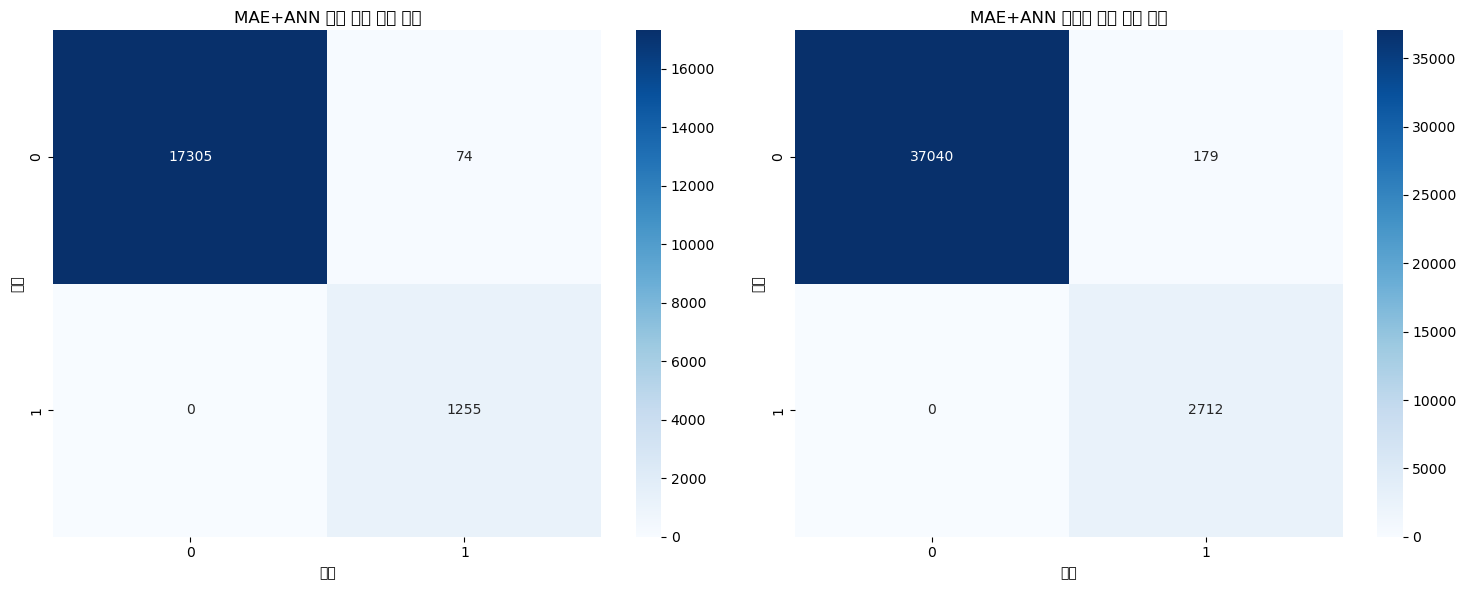

C:\Users\이희창\AppData\Local\Temp\ipykernel_12628\3548296653.py:167: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\이희창\AppData\Local\Temp\ipykernel_12628\3548296653.py:167: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\이희창\AppData\Local\Temp\ipykernel_12628\3548296653.py:167: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\이희창\AppData\Local\Temp\ipykernel_12628\3548296653.py:167: UserWarning: Glyph 51221 (\N{HANGUL SYLLABLE JEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\이희창\AppData\Local\Temp\ipykernel_12628\3548296653.py:167: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\이희창\AppData\Local\Temp\ipykernel_12628\3548296653.py:167: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from f

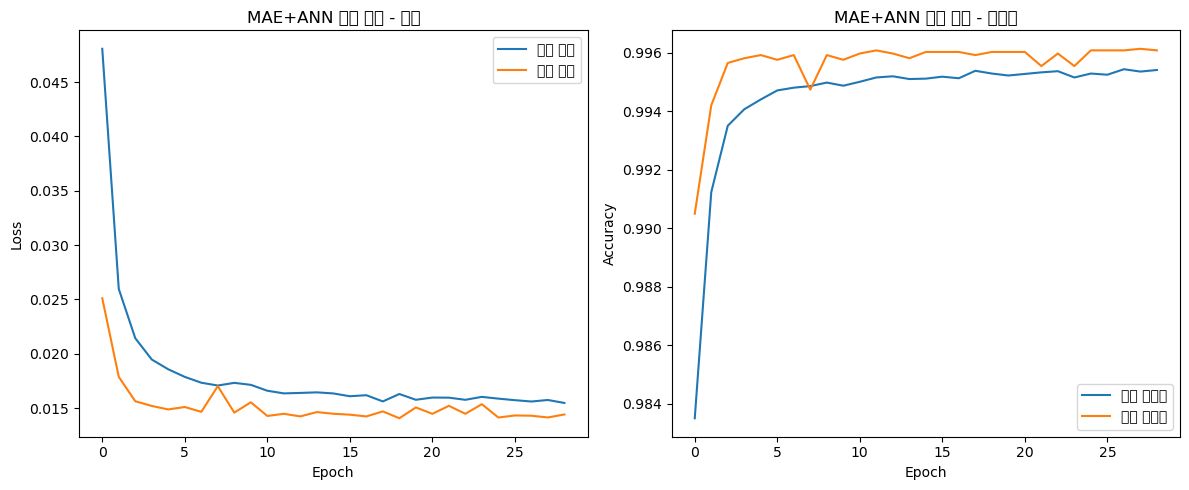


===== 모델 성능 비교 =====
Metric       ANN      MAE+ANN  Improvement 
---------------------------------------------
Accuracy     0.9960   0.9955     -0.05%
Precision    0.9449   0.9381     -0.72%
Recall       0.9996   1.0000     +0.04%
F1-Score     0.9715   0.9681     -0.36%
AUC          0.9993   0.9989     -0.03%

특성 압축: 184 -> 32 (5.8:1 압축)

기본 ANN 테스트 정확도: 0.9960
MAE+ANN 테스트 정확도: 0.9955
기본 ANN 테스트 AUC: 0.9993
MAE+ANN 테스트 AUC: 0.9989


In [10]:
def apply_mae_ann_model(X_train, y_train, X_val, y_val, X_test, y_test, encoder):
    """
    MAE의 encoder를 특성 추출기로 사용하여 ANN 모델을 적용하고 성능을 평가합니다.
    """
    print("MAE + ANN 모델 학습 및 평가 시작...")
    start_time = time.time()
    
    # MAE encoder로 특성 추출
    print("MAE encoder로 특성 추출 중...")
    X_train_encoded = encoder.predict(X_train)
    X_val_encoded = encoder.predict(X_val)
    X_test_encoded = encoder.predict(X_test)
    
    # 입력 차원 계산 (encoder 출력 차원)
    input_dim = X_train_encoded.shape[1]
    print(f"원본 특성 수: {X_train.shape[1]} -> 인코딩된 특성 수: {input_dim}")
    
    # 모델 구성 (encoder 출력을 입력으로 받는 분류기)
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Early Stopping 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # 모델 학습 (인코딩된 데이터 사용)
    print("모델 학습 중...")
    history = model.fit(
        X_train_encoded, y_train,
        validation_data=(X_val_encoded, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 검증 세트 예측
    y_val_prob = model.predict(X_val_encoded).flatten()
    y_val_pred = (y_val_prob >= 0.5).astype(int)
    
    # 테스트 세트 예측
    y_test_prob = model.predict(X_test_encoded).flatten()
    y_test_pred = (y_test_prob >= 0.5).astype(int)
    
    # 성능 평가
    # 검증 세트 성능
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_prob)
    
    # 테스트 세트 성능
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob)
    
    # 실행 시간 계산
    end_time = time.time()
    execution_time = end_time - start_time
    
    # 결과 요약
    results = {
        'model_summary': model.summary(),
        'history': history.history,
        'validation': {
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auc': val_auc,
            'confusion_matrix': confusion_matrix(y_val, y_val_pred),
            'classification_report': classification_report(y_val, y_val_pred, output_dict=True)
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'auc': test_auc,
            'confusion_matrix': confusion_matrix(y_test, y_test_pred),
            'classification_report': classification_report(y_test, y_test_pred, output_dict=True)
        },
        'execution_time': execution_time,
        'encoded_features': {
            'original_dim': X_train.shape[1],
            'encoded_dim': input_dim,
            'compression_ratio': X_train.shape[1] / input_dim
        }
    }
    
    # 결과 출력
    print("\n===== MAE + ANN 모델 성능 =====")
    print(f"실행 시간: {execution_time:.2f}초")
    print(f"특성 압축 비율: {results['encoded_features']['compression_ratio']:.2f}:1")
    
    print("\n검증 세트 성능:")
    print(f"정확도: {val_accuracy:.4f}")
    print(f"정밀도: {val_precision:.4f}")
    print(f"재현율: {val_recall:.4f}")
    print(f"F1 점수: {val_f1:.4f}")
    print(f"AUC: {val_auc:.4f}")
    
    print("\n테스트 세트 성능:")
    print(f"정확도: {test_accuracy:.4f}")
    print(f"정밀도: {test_precision:.4f}")
    print(f"재현율: {test_recall:.4f}")
    print(f"F1 점수: {test_f1:.4f}")
    print(f"AUC: {test_auc:.4f}")
    
    # 혼동 행렬 시각화
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.heatmap(results['validation']['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('MAE+ANN 검증 세트 혼동 행렬')
    plt.xlabel('예측')
    plt.ylabel('실제')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(results['test']['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title('MAE+ANN 테스트 세트 혼동 행렬')
    plt.xlabel('예측')
    plt.ylabel('실제')
    
    plt.tight_layout()
    plt.show()
    
    # 학습 과정 시각화
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='훈련 손실')
    plt.plot(history.history['val_loss'], label='검증 손실')
    plt.title('MAE+ANN 학습 과정 - 손실')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='훈련 정확도')
    plt.plot(history.history['val_accuracy'], label='검증 정확도')
    plt.title('MAE+ANN 학습 과정 - 정확도')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model, results

def compare_models(ann_results, mae_ann_results):
    """
    기본 ANN과 MAE+ANN 모델의 성능을 비교합니다.
    """
    print("\n===== 모델 성능 비교 =====")
    
    comparison_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC'],
        'ANN': [
            ann_results['test']['accuracy'],
            ann_results['test']['precision'],
            ann_results['test']['recall'],
            ann_results['test']['f1'],
            ann_results['test']['auc']
        ],
        'MAE+ANN': [
            mae_ann_results['test']['accuracy'],
            mae_ann_results['test']['precision'],
            mae_ann_results['test']['recall'],
            mae_ann_results['test']['f1'],
            mae_ann_results['test']['auc']
        ]
    }
    
    # 개선율 계산
    comparison_data['Improvement'] = [
        ((mae_ann - ann) / ann * 100) if ann != 0 else 0
        for mae_ann, ann in zip(comparison_data['MAE+ANN'], comparison_data['ANN'])
    ]
    
    # 결과 출력
    print(f"{'Metric':<12} {'ANN':<8} {'MAE+ANN':<8} {'Improvement':<12}")
    print("-" * 45)
    for i, metric in enumerate(comparison_data['Metric']):
        print(f"{metric:<12} {comparison_data['ANN'][i]:<8.4f} {comparison_data['MAE+ANN'][i]:<8.4f} {comparison_data['Improvement'][i]:>+7.2f}%")
    
    print(f"\n특성 압축: {mae_ann_results['encoded_features']['original_dim']} -> {mae_ann_results['encoded_features']['encoded_dim']} " +
          f"({mae_ann_results['encoded_features']['compression_ratio']:.1f}:1 압축)")
    
    return comparison_data

# 필요한 라이브러리 import
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

def apply_ann_model(X_train, y_train, X_val, y_val, X_test, y_test):
    """
    전처리된 데이터에 ANN 모델을 적용하고 성능을 평가합니다.
    """
    print("ANN 모델 학습 및 평가 시작...")
    start_time = time.time()
    
    # 입력 차원 계산
    input_dim = X_train.shape[1]
    
    # 모델 구성
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Early Stopping 설정
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    
    # 모델 학습
    print("모델 학습 중...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=1
    )
    
    # 검증 세트 예측
    y_val_prob = model.predict(X_val).flatten()
    y_val_pred = (y_val_prob >= 0.5).astype(int)
    
    # 테스트 세트 예측
    y_test_prob = model.predict(X_test).flatten()
    y_test_pred = (y_test_prob >= 0.5).astype(int)
    
    # 성능 평가
    # 검증 세트 성능
    val_accuracy = accuracy_score(y_val, y_val_pred)
    val_precision = precision_score(y_val, y_val_pred)
    val_recall = recall_score(y_val, y_val_pred)
    val_f1 = f1_score(y_val, y_val_pred)
    val_auc = roc_auc_score(y_val, y_val_prob)
    
    # 테스트 세트 성능
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred)
    test_recall = recall_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred)
    test_auc = roc_auc_score(y_test, y_test_prob)
    
    # 실행 시간 계산
    end_time = time.time()
    execution_time = end_time - start_time
    
    # 결과 요약
    results = {
        'model_summary': model.summary(),
        'history': history.history,
        'validation': {
            'accuracy': val_accuracy,
            'precision': val_precision,
            'recall': val_recall,
            'f1': val_f1,
            'auc': val_auc,
            'confusion_matrix': confusion_matrix(y_val, y_val_pred),
            'classification_report': classification_report(y_val, y_val_pred, output_dict=True)
        },
        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1,
            'auc': test_auc,
            'confusion_matrix': confusion_matrix(y_test, y_test_pred),
            'classification_report': classification_report(y_test, y_test_pred, output_dict=True)
        },
        'execution_time': execution_time
    }
    
    # 결과 출력
    print("\n===== ANN 모델 성능 =====")
    print(f"실행 시간: {execution_time:.2f}초")
    
    print("\n검증 세트 성능:")
    print(f"정확도: {val_accuracy:.4f}")
    print(f"정밀도: {val_precision:.4f}")
    print(f"재현율: {val_recall:.4f}")
    print(f"F1 점수: {val_f1:.4f}")
    print(f"AUC: {val_auc:.4f}")
    
    print("\n테스트 세트 성능:")
    print(f"정확도: {test_accuracy:.4f}")
    print(f"정밀도: {test_precision:.4f}")
    print(f"재현율: {test_recall:.4f}")
    print(f"F1 점수: {test_f1:.4f}")
    print(f"AUC: {test_auc:.4f}")
    
    return model, results

# 사용 예시:
# 1. 기본 ANN 모델 학습
print("=== 기본 ANN 모델 학습 ===")
best_ann_model, ann_results = apply_ann_model(X_train, y_train, X_val, y_val, X_test, y_test)

# 2. MAE + ANN 모델 학습 (앞서 학습한 encoder 사용)
print("\n=== MAE + ANN 모델 학습 ===")
mae_ann_model, mae_ann_results = apply_mae_ann_model(X_train, y_train, X_val, y_val, X_test, y_test, encoder)

# 3. 성능 비교
comparison = compare_models(ann_results, mae_ann_results)

# 결과 확인
print(f"\n기본 ANN 테스트 정확도: {ann_results['test']['accuracy']:.4f}")
print(f"MAE+ANN 테스트 정확도: {mae_ann_results['test']['accuracy']:.4f}")
print(f"기본 ANN 테스트 AUC: {ann_results['test']['auc']:.4f}")
print(f"MAE+ANN 테스트 AUC: {mae_ann_results['test']['auc']:.4f}")